<a href="https://colab.research.google.com/github/sabyasm/m4/blob/master/m4_18112019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pysurvival &> /dev/null

In [0]:
!curl -Lo m4.pkl https://manu00.s3-us-west-2.amazonaws.com/m4.pkl &> /dev/null

In [3]:
#### 1 - Importing packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.parametric import GompertzModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
# Building training and testing sets
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
# Reading the dataset
raw_dataset = pd.read_pickle("m4.pkl")

In [5]:
raw_dataset.columns

Index(['PolicyNumber', 'CoverageNumber', 'IssueAge', 'PolicyYear',
       'AttainedAge', 'IssueDate', 'MaturityDate', 'FaceAmount',
       'SmokerStatus', 'Gender', 'OccupationClass', 'CurrentProvince',
       'COLAIndicator', 'benefitPeriod', 'benefitPeriod_grouped',
       'benefitExpiryDate', 'DisabilityDuration', 'disabilityAge',
       'DisabilityReason', 'productDesign', 'EliminationPeriod',
       'EliminationPeriod_grouped', 'policyStartDate', 'policyEndDate',
       'exposureStartDate', 'exposureEndDate', 'TerminationEvent',
       'terminationReason', 'train'],
      dtype='object')

In [6]:
raw_dataset.head()

,PolicyNumber,CoverageNumber,IssueAge,PolicyYear,AttainedAge,IssueDate,MaturityDate,FaceAmount,SmokerStatus,Gender,OccupationClass,CurrentProvince,COLAIndicator,benefitPeriod,benefitPeriod_grouped,benefitExpiryDate,DisabilityDuration,disabilityAge,DisabilityReason,productDesign,EliminationPeriod,EliminationPeriod_grouped,policyStartDate,policyEndDate,exposureStartDate,exposureEndDate,TerminationEvent,terminationReason,train
0,H 0826898,2,23,21,43,1990-05-08,2010-05-31,100.0,N,M,2A,NS,0,2 years,Short-Term,2012-04-14,6,56,Other cancer,IncomeReplacement,120,120+,2010-05-08,2011-05-07,2010-05-16,2010-06-15,1,Death,1
1,H 0828055,1,21,41,61,1976-10-15,2021-01-15,200.0,N,M,A,QC,0,2 years,Short-Term,2018-08-23,5,60,Other accident/poisonings,IncomeReplacement,7,00-30,2016-10-15,2017-10-14,2016-11-25,2016-12-24,0,None,0
2,H 0833653,1,35,30,64,1978-12-01,2009-04-01,200.0,N,M,3A,NS,0,To age 65,ToAge65,2009-03-29,5,63,Other genitourinary/reproductive disorders,IncomeReplacement,90,90,2007-12-01,2008-11-30,2008-05-26,2008-06-25,1,Other,1
3,H 0834890,1,30,30,59,1979-05-20,2014-08-20,725.0,N,M,2A,AB,0,5 years,Short-Term,2008-08-28,64,53,Other musculoskeletal disorders,IncomeReplacement,120,120+,2008-05-20,2009-05-19,2008-08-01,2008-08-31,0,None,1
4,H 0840908,1,28,33,60,1981-11-03,2018-05-03,500.0,N,M,A,QC,0,2 years,Short-Term,2015-10-16,4,60,Other musculoskeletal disorders,IncomeReplacement,30,00-30,2013-11-03,2014-11-02,2013-12-17,2014-01-16,1,Other,1


In [7]:
raw_dataset.benefitPeriod.unique()

array(['2 years', 'To age 65', '5 years', 'Lifetime/To age 101',
       '18 months', '10 years', '1 year', '3 years', '4 months',
       'Not covered', '15 months'], dtype=object)

In [0]:
def time_remaining(row):
  remaining = np.nan
  if row['benefitPeriod']=='2 years':
    remaining = 24 - row['DisabilityDuration']
  if row['benefitPeriod']=='To age 65':
    remaining = 12*65 - row['disabilityAge'] - row['DisabilityDuration']
  if row['benefitPeriod']=='Lifetime/To age 101':
    remaining = 12*101 - row['disabilityAge'] - row['DisabilityDuration']
  if row['benefitPeriod']=='5 years':
    remaining = 60 - row['DisabilityDuration']
  if row['benefitPeriod']=='18 months':
    remaining = 18 - row['DisabilityDuration']
  if row['benefitPeriod']=='10 years':
    remaining = 120 - row['DisabilityDuration']
  if row['benefitPeriod']=='1 year':
    remaining = 12 - row['DisabilityDuration']
  if row['benefitPeriod']=='3 years':
    remaining = 36 - row['DisabilityDuration']
  if row['benefitPeriod']=='4 months':
    remaining = 4 - row['DisabilityDuration']
  if row['benefitPeriod']=='Not covered':
    remaining = 0
  if row['benefitPeriod']=='15 months':
    remaining = 15 - row['DisabilityDuration']
  return remaining


In [0]:
raw_dataset["remaining_months"] = raw_dataset.apply(time_remaining, axis=1)

In [0]:
#raw_dataset[raw_dataset.remaining_months<1].groupby("remaining_months").count()

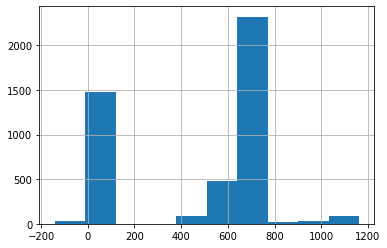

In [12]:
raw_dataset.remaining_months.hist()

In [0]:
#feature ideas
# benefit period in yrs
# elimination period in months?

In [0]:
to_drop = ['PolicyNumber', 'IssueDate', 'IssueAge','AttainedAge', 'MaturityDate', 'benefitExpiryDate', 'policyStartDate', 'policyEndDate',
           'exposureStartDate', 'exposureEndDate','terminationReason']
           
raw_dataset.drop(columns=to_drop,inplace=True)

In [0]:
raw_dataset['CurrentAge'] = raw_dataset['disabilityAge'] + raw_dataset['DisabilityDuration']

In [0]:
categories = ['SmokerStatus', 'Gender', 'OccupationClass', 'CurrentProvince','COLAIndicator', 'benefitPeriod',
              'benefitPeriod_grouped','DisabilityReason', 'productDesign', 'EliminationPeriod', 
              'EliminationPeriod_grouped']
dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)    


In [0]:
train_data = dataset[dataset.train==1]
pred_data = dataset[dataset.train==0]

In [23]:
train_data.drop(columns=['train'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
dataset.shape # (4539, 127)
train_data.shape #(3348, 127)

(3348, 111)

In [0]:
# Creating the time and event columns
time_column = 'DisabilityDuration'
event_column = 'TerminationEvent'

# Extracting the features
features = np.setdiff1d(train_data.columns, [time_column, event_column] ).tolist()

In [26]:
%%time
# Checking for null values
N_null = sum(train_data[features].isnull().sum())
print("The train_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(train_data.duplicated(keep='first'))
train_data = train_data.drop_duplicates(keep='first').reset_index(drop=True)
print("The train_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = train_data.shape[0]

The train_dataset contains 0 null values
The train_dataset contains 1 duplicates
CPU times: user 57.5 ms, sys: 3.84 ms, total: 61.4 ms
Wall time: 61.1 ms


In [27]:
train_data.shape

(3347, 111)

In [0]:
X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(train_data[features],train_data[time_column], train_data[event_column],test_size = 0.25, random_state=12345, stratify=train_data[event_column])

In [29]:
X_train.shape

(2510, 109)

In [41]:
k = 23
predicted = nonlinear_coxph.predict_survival(X_test.values[k, :], t=T_test.iloc[k]).flatten()
print(predicted)
print(E_test.iloc[k])

[0.38107995]


In [36]:
%%time
##6
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel

# Fitting the model
csf = ConditionalSurvivalForestModel(num_trees=200)
csf.fit(X_train, T_train, E_train, max_features='sqrt',
        max_depth=5, min_node_size=20, alpha=0.05, minprop=0.1) #0.74

CPU times: user 5min 16s, sys: 285 ms, total: 5min 17s
Wall time: 2min 40s


In [44]:
# Computing variables importance
csf.variable_importance_table.head(20)

,feature,importance,pct_importance
0,CurrentAge,11.063080,0.131861
1,remaining_months,8.963027,0.106831
2,EliminationPeriod_grouped_120+,5.125826,0.061095
3,EliminationPeriod_120,4.669643,0.055658
4,PolicyYear,4.328423,0.051591
5,productDesign_IncomeReplacement,3.958964,0.047187
6,productDesign_Venture_Total,3.549037,0.042301
7,FaceAmount,3.542233,0.042220
8,benefitPeriod_grouped_Short-Term,3.221233,0.038394
9,DisabilityReason_Other cancer,3.076306,0.036667


In [45]:
#cross validation
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index)) #0.75

C-index: 0.75


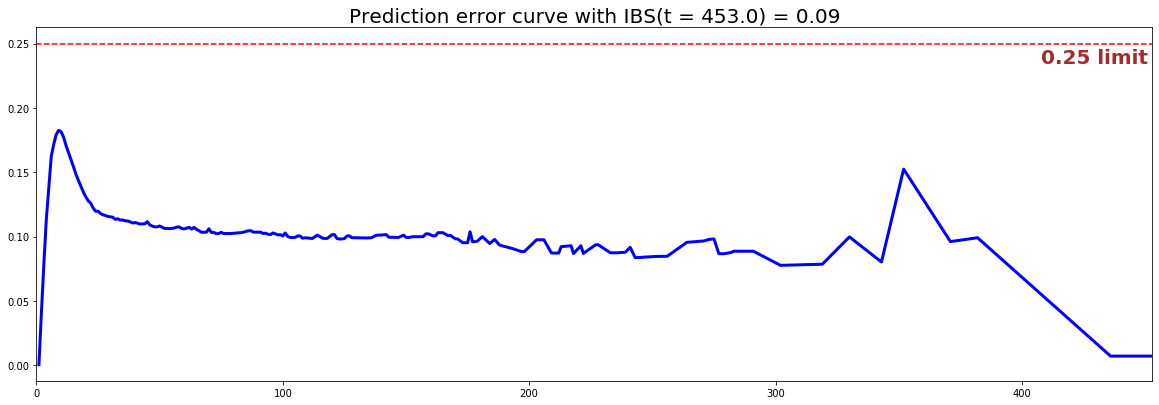

IBS: 0.09


In [46]:
ibs = integrated_brier_score(csf, X_test, T_test, E_test, t_max=600,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

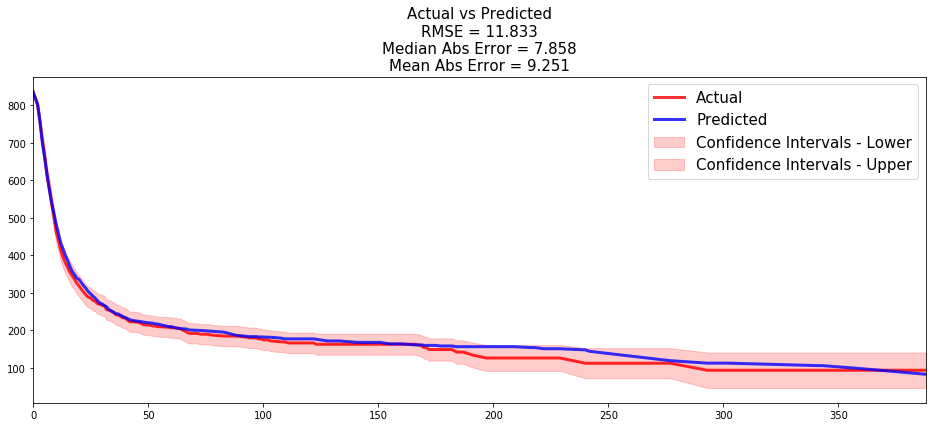

In [47]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(csf, X_test, T_test, E_test,
                            is_at_risk = True,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])